In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_DEFG106017_5.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.688961,-0.098407,-0.878946,1.908757,1.908757,-0.572337,-0.680069,-0.344434,-0.847799,-0.559022,1.176249,0.379582,-0.304934,-0.078675,-0.150104,-0.440423,-0.879612,-0.255268,1.415665,-0.029548,0.543690,-0.520336,-0.036999,-0.797214,-0.351647,1.0,-0.126381,-0.231636,-0.749244,3.41565,-0.157698,-0.194825,-0.220784,-0.218218,-0.561299,-0.069338,-0.252217,-0.17609,-0.08901,-0.598141,1.218142,-0.708013,0.0
1,-0.955672,-0.272715,0.853446,0.113095,0.113095,0.621456,-0.892889,-0.745154,-0.932905,-0.449493,0.415315,-0.463741,-0.896243,-0.078675,-0.150104,-0.440423,0.314916,-0.255268,1.415665,1.342791,1.503181,-1.587261,-0.036999,1.254368,-0.351647,-1.0,-0.126381,-0.231636,1.334679,-0.29277,-0.157698,-0.194825,-0.220784,-0.218218,-0.561299,-0.069338,-0.252217,-0.17609,-0.08901,-0.598141,1.218142,-0.708013,0.0
2,0.143178,-0.083250,1.574731,-0.656475,-0.656475,-0.572337,0.145642,0.256648,0.939420,-0.097825,2.698116,2.909549,-0.896243,-0.078675,-0.150104,0.894995,-0.355482,-0.255268,1.415665,-0.029548,0.543690,-0.520336,-0.036999,1.254368,-0.351647,-1.0,-0.126381,-0.231636,-0.749244,-0.29277,-0.157698,-0.194825,-0.220784,-0.218218,-0.561299,-0.069338,3.964846,-0.17609,-0.08901,-0.598141,1.218142,-0.708013,1.0
3,-0.571608,-0.242401,1.060462,-0.912998,-0.912998,1.408668,-0.452957,-0.344434,-0.422271,-0.422451,2.698116,0.379582,0.331859,-0.078675,-0.150104,0.894995,-0.562696,-0.255268,1.415665,1.342791,2.142842,0.013127,-0.036999,1.254368,-0.351647,-1.0,-0.126381,-0.231636,1.334679,-0.29277,-0.157698,-0.194825,-0.220784,-0.218218,-0.561299,-0.069338,-0.252217,-0.17609,-0.08901,-0.598141,1.218142,-0.708013,1.0
4,0.207189,-0.227244,1.467955,-0.143429,-0.143429,-0.996220,0.175789,0.256648,-0.081848,0.130144,-0.345619,-0.463741,-0.896243,-0.078675,-0.150104,0.894995,1.168150,-0.255268,1.415665,-0.029548,0.223859,1.080052,-0.036999,1.254368,-0.351647,-1.0,-0.126381,-0.231636,-0.749244,3.41565,-0.157698,-0.194825,-0.220784,-0.218218,-0.561299,-0.069338,-0.252217,-0.17609,-0.08901,-0.598141,-0.820922,1.412403,1.0


In [4]:
data.shape

(2926, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    2260
0.0     666
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(2926, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77645051 0.77435897 0.77777778 0.76752137 0.76068376]
0.7713584784574545


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  33,  633],
       [  36, 2224]])

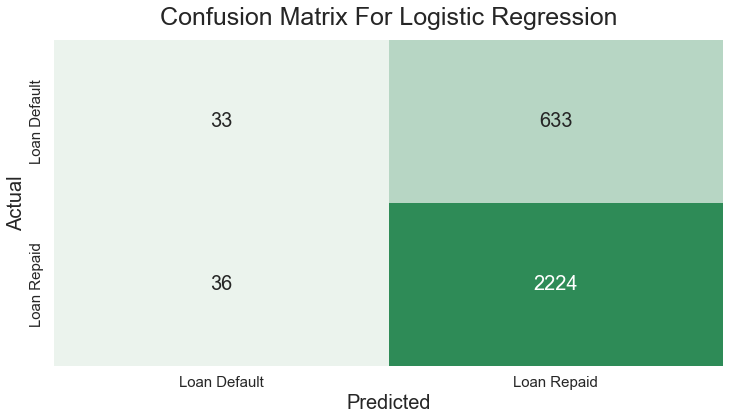

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.7713602187286398

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

2224
633
36
33
0.7713602187286398


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    2260
0.0     666
Name: loan_status_bin, dtype: int64

0.7723855092276145


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.7784389219460973

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [18]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [19]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.77645051 0.77435897 0.77777778 0.76752137 0.76068376]
0.7713584784574545


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  33,  633],
       [  36, 2224]])

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.3404435 , 0.6595565 ],
       [0.31326633, 0.68673367],
       [0.21914773, 0.78085227],
       ...,
       [0.14340387, 0.85659613],
       [0.27220702, 0.72779298],
       [0.2075845 , 0.7924155 ]])

In [85]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.865).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [86]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 586,   80],
       [1713,  547]])

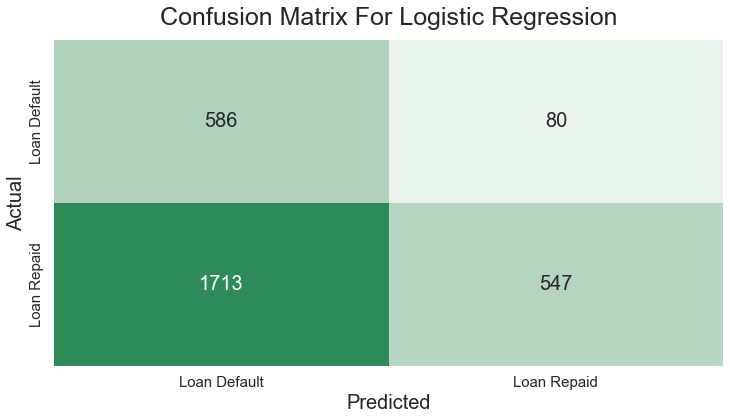

In [87]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [88]:
accuracy_score(y, y_pred_success)

0.38721804511278196

In [89]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

547
80
1713
586
0.38721804511278196


In [90]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8724082934609251

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 